# CafeBazaar NLP Workshop - Summer 2019

# Part 2

# Predicting Applications Category Based on Descriptions

The objective of this analysis is to train **FastText** classifier to find applications category based on their descriptions. The sections of this analysis include:
- Using word embeddings to classify
    - with pretrained word vectors
    - without pretrained word vectors
- Evaluating the results
- Thinking of better ways to create *train* dataset.

# First Thing First: Load the Data

In [1]:
%load_ext wurlitzer

In [2]:
import pandas as pd
import numpy as np

Use your processed data file from part 1 of the workshop.

In [7]:
data = pd.read_pickle("output-data/processed_data.pkl")

# Creating Train, and Test Datasets

Use any desired method to create *train*, and *test* datasets. Use about $80\%$ of whole data at random as *train*, and others as *test* datasets.

In [8]:
np.random.seed(0)
msk = np.random.rand(len(data), ) < 0.8

train = data[msk]
test = data[~msk]

In [9]:
train

package_name  \
0                       com.adobe.reader   
1                   com.arabic.smsviewer   
2        com.bestcoolfungames.antsmasher   
3                        com.bwx.bequick   
4                   com.dataviz.docstogo   
...                                  ...   
44188           ir.salamcinama.dl.inline   
44191  ir.mservices.mybook.inline.b36797   
44192                      atg214.inline   
44193  ir.mservices.mybook.inline.b17862   
44194  ir.mservices.mybook.inline.b25944   

                                          description_fa  \
0      <p>استاندارد جهانی برای نمایش و استفاده از اسن...   
1      <p>برنامه‌ای که امکان خواندن و ارسال متن عربی/...   
2      <p>با انگشتان خود مورچه‌ها را له کنید!</p> باز...   
3      <p>این برنامه اجازه تغییر تنظیمات را به سریع‌ت...   
4      <p>نمایش فایل‌های Word، Excel و PowerPoint همگ...   
...                                                  ...   
44188  <p>دانلود قانونی قسمت‌های مختلف سریال ساخت ایر...   
44191  <p>بی‌درنگ کتاب بخوانید!</p>\n<p>بارها در جامع...   
44192         <p>گل اول ژاپن به ایران (اوساکو) <br> </p>   
44193  <p>«رها در باد» نوشته جوجو مویز(-۱۹۶۹)، نویسند...   
44194  <p>«۳۰ سالگی، راهی به سوی زندگی دلخواه» کتابی ...   

                 application_name_fa      category_name  category_id   game  \
0                                          Productivity            4  False   
1                                         Communication            6  False   
2                                                Arcade           46   True   
3                       تنظیمات سریع       Productivity            4  False   
4                                              Business            8  False   
...                              ...                ...          ...    ...   
44188            دانلود ساخت ایران ۲      Media & Video           12  False   
44191       بیشعوری - کتاب الکترونیک  Books & Reference            9  False   
44192  گل اول ژاپن به ایران (اوساکو)             Sports           15  False   
44193      رها در باد - رمان عاشقانه  Books & Reference            9  False   
44194         ۳۰ سالگی - کتاب موفقیت          Lifestyle           23  False   

       installed_count label_category      label_game  \
0              1755353     __label__4  __label__false   
1                17637     __label__6  __label__false   
2                92352    __label__46   __label__true   
3                  521     __label__4  __label__false   
4               116933     __label__8  __label__false   
...                ...            ...             ...   
44188            38160    __label__12  __label__false   
44191            31816     __label__9  __label__false   
44192              728    __label__15  __label__false   
44193             5808     __label__9  __label__false   
44194             1920    __label__23  __label__false   

                                       preprocessed_text  
0      استاندارد جهانی نمایش استفاده اسناد فرمت pdf ا...  
1      برنامه خواندن ارسال متن عرب فارس پیام کوتاه فر...  
2      انگ مورچه له کرد#کن بازی قابل‌مقایسه پرندگان خ...  
3      برنامه اجازه تنظیمات سریع نحو مهیا ساخت#ساز اف...  
4      نمایش فایل‌های word excel powerpoint همگی برنا...  
...                                                  ...  
44188  دانلود قانون قسمت مختلف سریال ساخت ایران کیفیت...  
44191  بی‌درنگ کتاب خواند#خوان جامعه برخورد کرده‌ایدک...  
44192                               گل ژاپن ایران اوساکو  
44193  رها باد نوشته جوجو مویز نویسنده زن انگلیسی #اس...  
44194  سالگی سو زندگی دلخواه کتاب زمینه موفقیت نوشته ...  

[35392 rows x 10 columns]

You may need to create `train.txt` (and also `test.txt`) with suitable text formating in order to feed them to `FastText` library.

In [10]:
with open('train.txt', 'w') as f:
    for i in range(train.shape[0]):
        row = train.iloc[i]
        proc_text = row.preprocessed_text
        label_category = row.label_category
        f.write("%s %s\n" % (label_category, proc_text))

with open('test.txt', 'w') as f:
    for i in range(test.shape[0]):
        row = test.iloc[i]
        proc_text = row.preprocessed_text
        label_game = row.label_category
        f.write("%s %s\n" % (label_game, proc_text))

You may also want to save your train, and test side of `data` dataframe in `.pkl` format under the `./output-data/classification_task/` path for further use.

In [11]:
train.to_pickle('./output-data/classification_task/train.pkl')
test.to_pickle('./output-data/classification_task/test.pkl')

Your train, and test data is ready now.

# Training with Pretrained Word Vectors

We are going to use `print-word-vectors` from `fasttext` library, and we need to pass in the pretrained vectors with our vocabulary.

Create `output-data/classification_task/processed_words.txt` and set it to be the all distinct word from `data['preprocessed_text']`. Each word in one line.

In [13]:
# data['proc']

In [14]:
words = []
for i in list(data['preprocessed_text']):
    for word in str(i).split():
        words.append(word)
words = list(set(words))

with open('processed_words.txt', 'w') as f:
    for item in words:
        f.write("%s\n" % item)

Now use `print-word-vectors` from fasttext and save the results.

In [15]:
import os 
os.environ["pretrained_path"] = "./input-data/cc"
os.environ["words_path"] = "./output-data/processed_words.txt"
os.environ["pretrained_vecs_path"] = "./output-data/fasttext_pretrained_vectors.txt"

In [16]:
%%sh
./fastText/build/fasttext print-word-vectors $pretrained_path < $words_path > $pretrained_vecs_path

In [17]:
%%sh
echo "$(cat $pretrained_vecs_path | wc -l) 300\n$(cat $pretrained_vecs_path)" > $pretrained_vecs_path

Now train a classifier using `fasttext` library with your *train* dataset.

In [18]:
os.environ["train_path"] = "train.txt"
os.environ["model_path"] = "output-data/classification_task/model_pretrained_vectors"

In [19]:
%%sh
./fastText/build/fasttext supervised -input $train_path -output $model_path -minCount 3 -minn 4 -maxn 6 -wordNgrams 3 -epoch 10 -dim 300 -pretrainedVectors $pretrained_vecs_path

Read 3M words
Number of words:  28316
Number of labels: 36
Progress: 100.0% words/sec/thread:    3951 lr:  0.000000 avg.loss:  2.194766 ETA:   0h 0m 0s


Now evaluate your model using `fasttext` library; also save *predictions probability* on *test* dataset.

In [20]:
os.environ["test_path"] = "test.txt"
os.environ["prediction_prob_path"] = "output-data/classification_task/prob-predictions.txt"

In [21]:
%%sh
./fastText/build/fasttext test $model_path.bin $test_path 1

N	8803
P@1	0.521
R@1	0.521


In [22]:
%%sh
./fastText/build/fasttext predict-prob $model_path.bin $test_path 1 > $prediction_prob_path

# Training with Pretrained Word Vectors


In this part train a classifier, and evaluate it without pretrained word vectors.

In [23]:
os.environ["model_path"] = "output-data/classification_task/model_trained_vectors"
os.environ["prediction_prob_path"] = "output-data/classification_task/prob-predictions_trained_vectors.txt"

In [33]:
# %%sh
# ./fastText/build/fasttext supervised -input $train_path -output $model_path -minCount 3 -minn 4 -maxn 6 -wordNgrams 3 -epoch 10 -dim 300

Read 3M words
Number of words:  28317
Number of labels: 36
Progress: 100.0% words/sec/thread:   20850 lr:  0.000000 loss:  2.457651 ETA:   0h 0m


In [34]:
# %%sh
# ./fastText/build/fasttext test $model_path.bin $test_path 1

N	8803
P@1	0.46
R@1	0.46


In [46]:
# %%sh
# ./fastText/build/fasttext predict-prob $model_path.bin $test_path 1  > $prediction_prob_path

# Ploting the Confusion Matrix

Now plot confusion matrix on the result of testing your both model (using pretrained word vectors, and not using them).

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(16, 12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Confusion Matrix for Model Which Used Pretrained Word Vectors

Normalized confusion matrix
[[0.5 0.1 0.  ... 0.  0.  0. ]
 [0.  0.8 0.  ... 0.  0.  0. ]
 [0.1 0.3 0.  ... 0.  0.  0. ]
 ...
 [0.  0.1 0.  ... 0.  0.  0. ]
 [0.  0.1 0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0.6]]


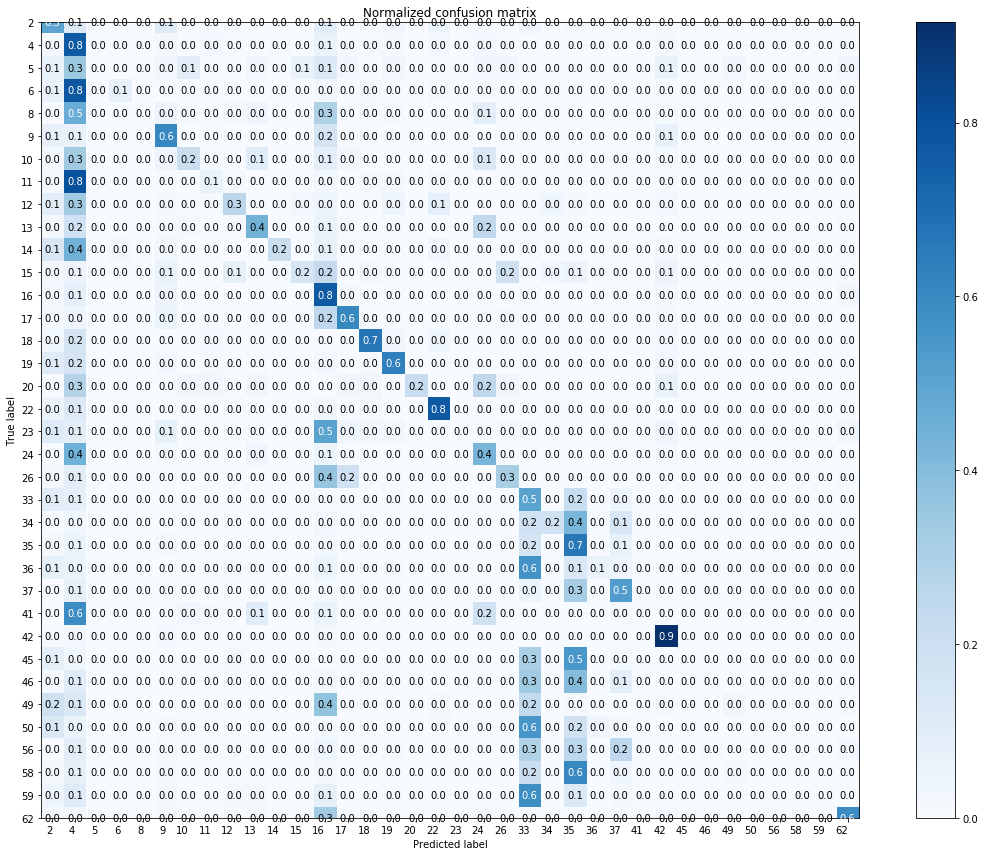

In [27]:
test_data = pd.read_pickle('output-data/classification_task/test.pkl')

y_true = list(test_data['label_category'])
y_true = [int(i.replace("__label__", "")) for i in y_true]

y_pred = list(pd.read_csv("output-data/classification_task/prob-predictions.txt",sep = ' ', names=['y_pred', 'prob'])['y_pred'])
y_pred = [int(i.replace("__label__", "")) for i in y_pred]

class_names = list(set(y_true))
class_names.sort()
class_names[1:4]

np.set_printoptions(precision=1)

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

### Confusion Matrix for Model Which Did not Use Pretrained Word Vectors

In [30]:
test_data = pd.read_pickle('output-data/classification_task/test.pkl')

y_true = list(test_data['label_category'])
y_true = [int(i.replace("__label__", "")) for i in y_true]

y_pred = list(pd.read_csv("output-data/classification_task/prob-predictions_trained_vectors.txt",sep = ' ', names=['y_pred', 'prob'])['y_pred'])
y_pred = [int(i.replace("__label__", "")) for i in y_pred]

class_names = list(set(y_true))
class_names.sort()
class_names[1:4]

np.set_printoptions(precision=1)

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

FileNotFoundError: [Errno 2] File b'prob-predictions_trained_vectors.txt' does not exist: b'prob-predictions_trained_vectors.txt'

What are your thoughts on these results?

# Upsampling

This part is made to create more **balanced** *train* dataset.

Use upsampling methods, and save your new train dataset to `train_balanced.pkl`, and `train_balanced.txt`. 

In [31]:
from sklearn.utils import resample

train_classes = [x for _, x in train.groupby('label_category')]
max_num = np.max([t.shape[0] for t in train_classes])

new_trainings = []
for t in train_classes:
    t_upsampled = resample(t,
                           replace=True, # sample with replacement
                           n_samples=max_num, # match number in majority class
                           random_state=27)
    new_trainings.append(t_upsampled)

train_balanced = pd.concat(new_trainings)
train_balanced.to_pickle('output-data/classification_task/train_balanced.pkl')

with open('output-data/classification_task/train_balanced.txt', 'w') as f:
    for i in range(train_balanced.shape[0]):
        row = train_balanced.iloc[i]
        proc_text = row.preprocessed_text
        label_category = row.label_category
        f.write("%s %s\n" % (label_category, proc_text))

Train a classifier using `fasttext` library on new train dataset (`train_balanced`).

Also evaluate your model, and plot the confusion matrix for your testing results.

In [34]:
os.environ["train_path"] = "output-data/classification_task/train_balanced.txt"
os.environ["model_path"] = "output-data/classification_task/model_pretrained_vectors_balanced"
os.environ["prediction_prob_path"] = "output-data/classification_task/prob-predictions_balanced.txt"

In [ ]:
%%sh
./fastText/build/fasttext supervised -input $train_path -output $model_path -minCount 3 -minn 4 -maxn 6 -wordNgrams 3 -epoch 10 -dim 300 -pretrainedVectors $pretrained_vecs_path

In [35]:
%%sh
./fastText/build/fasttext test $model_path.bin $test_path 1

libc++abi.dylib: terminating with uncaught exception of type std::invalid_argument: output-data/classification_task/model_pretrained_vectors_balanced.bin cannot be opened for loading!
sh: line 1:  9153 Abort trap: 6           ./fastText/build/fasttext test $model_path.bin $test_path 1


CalledProcessError: Command 'b'./fastText/build/fasttext test $model_path.bin $test_path 1\n'' returned non-zero exit status 134.

In [49]:
%%sh
./fastText/build/fasttext predict-prob $model_path.bin $test_path 1  > $prediction_prob_path

Normalized confusion matrix
[[0.4 0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.8 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.7 0.  0. ]
 [0.  0.  0.  ... 0.  0.6 0. ]
 [0.  0.  0.  ... 0.  0.  0.9]]


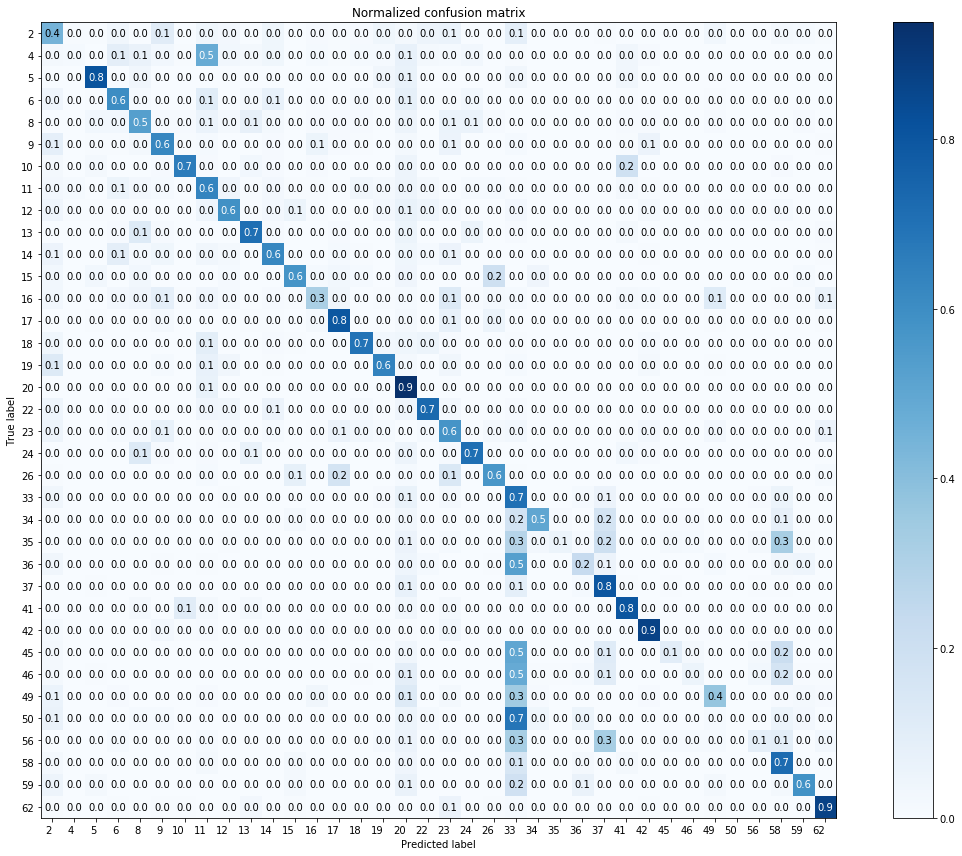

In [50]:
test_data = pd.read_pickle('output-data/classification_task/test.pkl')

y_true = list(test_data['label_category'])
y_true = [int(i.replace("__label__", "")) for i in y_true]

y_pred = list(pd.read_csv("output-data/classification_task/prob-predictions_balanced.txt",sep = ' ', names=['y_pred', 'prob'])['y_pred'])
y_pred = [int(i.replace("__label__", "")) for i in y_pred]

class_names = list(set(y_true))
class_names.sort()
class_names[1:4]

np.set_printoptions(precision=1)

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Part 2 - The End.